In [1]:
#disk_disk

In [2]:
import numpy as np
import sklearn
import kmapper as km
import pygeodesic
import pygeodesic.geodesic as geodesic
from scipy.spatial import distance_matrix
import vtk
from mpl_toolkits.mplot3d import Axes3D  # noqa
import scipy as sp
import numpy as np
import networkx as nx
import random
import math
from networkx.algorithms import approximation
from scipy.spatial.distance import cdist
import open3d as o3d
import matplotlib
import matplotlib.pyplot as plt
import time
from scipy.sparse import coo_matrix, csr_matrix

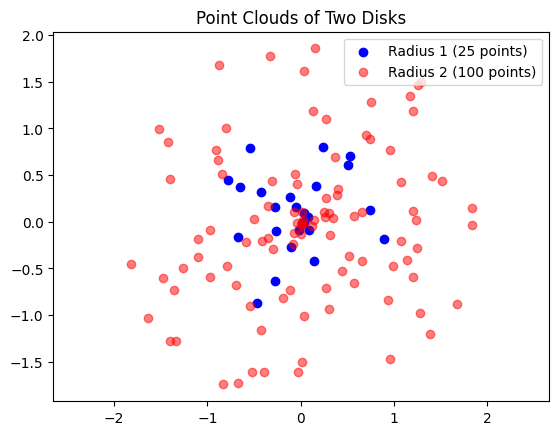

625
10000
1.861844131246017
3.8788118426059315


In [3]:
random_state=1
np.random.seed(random_state)
random.seed(random_state)

def generate_point_cloud(radius, num_points):
    """
    Generate a point cloud within a disc of a given radius.

    :param radius: Radius of the disc.
    :param num_points: Number of points to generate.
    :return: Array of points in the disc.
    """
    # Generate random angles and radii
    angles = np.random.uniform(0, 2 * np.pi, num_points)
    radii = np.random.uniform(0, radius, num_points)

    # Convert polar coordinates to Cartesian coordinates
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)

    return x, y

# Number of points in the larger disc
N = 100

# Generate point clouds for both discs
x_small, y_small = generate_point_cloud(1, N // 4)
x_large, y_large = generate_point_cloud(2, N)

# Plotting
plt.figure()
plt.scatter(x_small, y_small, color='blue', label='Radius 1 (25 points)')
plt.scatter(x_large, y_large, color='red', alpha=0.5, label='Radius 2 (100 points)')
plt.axis('equal')
plt.legend()
plt.title('Point Clouds of Two Disks')
plt.show()


C1 = cdist(np.column_stack((x_small, y_small)), np.column_stack((x_small, y_small)))
C2 = cdist(np.column_stack((x_large, y_large)), np.column_stack((x_large, y_large)))


print(np.size(C1))
print(np.size(C2))

print(np.max(C1))
print(np.max(C2))

#np.savetxt(f'DiskDisk_C1_0107.csv', C1, delimiter=',', fmt='%.10f')
#np.savetxt(f'DiskDisk_C2_0107.csv', C2, delimiter=',', fmt='%.10f')  


In [4]:
def vertex_with_most_edges(graph):
    degrees = dict(graph.degree())     
    max_degree = max(degrees.values())
    max_degree_vertices = [vertex for vertex, degree in degrees.items() if degree == max_degree]

    return max_degree_vertices, max_degree

In [5]:
def is_minimal_vertex_cover(G, vertex_cover):
        # Check if the set covers all edges
        for u, v in G.edges():
            if u not in vertex_cover and v not in vertex_cover:
                return False  # The set does not cover all edges
        # Check for minimality
        for vertex in vertex_cover:
            # Try removing the vertex and see if it's still a vertex cover
            reduced_cover = vertex_cover - {vertex}
            if all(u in reduced_cover or v in reduced_cover for u, v in G.edges()):
                return False  # Found a smaller vertex cover
        return True  # The vertex cover is minimal

In [6]:
#version1: too slow

In [7]:
#def is_vertex_cover_incidence(incidence_matrix_coo, cover, vertices):
    ## vertices need to be a list
    #cover_indices = set([vertices.index(v) for v in cover])

    #column_sums = np.zeros(incidence_matrix_coo.shape[1])
    #for row, col in zip(incidence_matrix_coo.row, incidence_matrix_coo.col):
        #if row in cover_indices:
            #column_sums[col] += 1

    #return np.min(column_sums) > 0

In [8]:
#version2

In [9]:
#######################################################

In [10]:
def get_cover_sum_0(
    D1: np.ndarray, 
    D2: np.ndarray,
    ratio: float = 0.0001,
    threshold: float = 0.02,
    random_state: int = 1,
    verbose: bool=False
):    

    np.random.seed(random_state)
    random.seed(random_state)

    n = D1.shape[0]
    m = D2.shape[0]
    C1 = D1.copy()
    C2 = D2.copy()
  
    #build graph and find an approximation of min vertex covering
    G = nx.Graph()
    tensor4 = np.zeros((n, m, n, m))

    C1_exp = C1[:, None, :, None]
    C2_exp = C2[None, :, None, :]
    tensor4 = (C1_exp - C2_exp)**2
    positions = np.where(tensor4 > threshold**2) 
    G = nx.Graph()
    G.add_edges_from(((p[0]+1, p[1]+1), (p[2]+1, p[3]+1)) for p in zip(*positions))  
    #print(f"Number of vertex: {G.number_of_nodes()}")
    vertices = list(G.nodes())
    edges = list(G.edges())
    
    row_indices = []
    col_indices = []
    for j, edge in enumerate(edges):
        u, v = edge
        u_index = vertices.index(u)
        v_index = vertices.index(v)
        row_indices.extend([u_index, v_index])
        col_indices.extend([j, j])

    data = [1] * len(row_indices)
    incidence_matrix = sp.sparse.csr_matrix((data, (row_indices, col_indices)), shape=(len(vertices), len(edges)))

    
    tuples_set = set()
    B = G.copy()
    initial_random_add = int(G.number_of_nodes() * ratio)
    
    for i in range(initial_random_add):
        vertex = random.choice(list(B.nodes))
        B.remove_node(vertex)
        tuples_set.add(vertex)

    while B.edges:
        vertices, degree = vertex_with_most_edges(B)
        vertex = random.choice(vertices)
        B.remove_node(vertex)
        tuples_set.add(vertex)
  
    inf_mask = np.zeros([n, m])
    test = 0

    if is_minimal_vertex_cover(G, tuples_set):
        test = 1
        for (i, j) in tuples_set:
            inf_mask[i-1, j-1] = 1
    else:
        minimal_cover = tuples_set.copy()
        tuples_list = list(tuples_set)
        
        for vertex in tuples_list:
            minimal_cover.remove(vertex)
            remaining_indices = [vertices.index(v) for v in tuples_list if v != vertex]
            A = incidence_matrix[remaining_indices, :]
            if not np.min(A.sum(axis=0)) > 0:
                minimal_cover.add(vertex)
           
        if is_minimal_vertex_cover(G, minimal_cover):
            test = 1
            for (i, j) in minimal_cover:
                inf_mask[i-1, j-1] = 1
        
    return inf_mask, test

In [11]:
def get_cover_sum_1(D1, D2, ratio=0.0001, threshold=0.02, random_state=1, verbose=False):
    np.random.seed(random_state)
    random.seed(random_state)

    n, m = D1.shape[0], D2.shape[0]
    C1, C2 = D1.copy(), D2.copy()
    tensor4 = (C1[:, None, :, None] - C2[None, :, None, :])**2
    positions = np.where(tensor4 > threshold**2)

    G = nx.Graph()
    G.add_edges_from(((p[0]+1, p[1]+1), (p[2]+1, p[3]+1)) for p in zip(*positions))

    vertices = list(G.nodes())
    vertex_to_index = {v: i for i, v in enumerate(vertices)}

    edges = list(G.edges())
    row_indices, col_indices = [], []
    for j, edge in enumerate(edges):
        u_index, v_index = vertex_to_index[edge[0]], vertex_to_index[edge[1]]
        row_indices.extend([u_index, v_index])
        col_indices.extend([j, j])

    data = [1] * len(row_indices)
    incidence_matrix = sp.sparse.csr_matrix((data, (row_indices, col_indices)), shape=(len(vertices), len(edges)))

    tuples_set, B = set(), G.copy()
    for _ in range(int(len(B) * ratio)):
        vertex = random.choice(list(B.nodes))
        B.remove_node(vertex)
        tuples_set.add(vertex)

    while B.edges:
        vertices, _ = vertex_with_most_edges(B)
        vertex = random.choice(vertices)
        B.remove_node(vertex)
        tuples_set.add(vertex)

    inf_mask = np.zeros([n, m])
    test = 0
    if is_minimal_vertex_cover(G, tuples_set):
        for (i, j) in tuples_set:
            test = 1
            inf_mask[i-1, j-1] = 1
    else:
        minimal_cover = tuples_set.copy()
        for vertex in list(minimal_cover):
            minimal_cover.remove(vertex)
            remaining_indices = [vertex_to_index[v] for v in minimal_cover]
            A = incidence_matrix[remaining_indices, :]
            if not np.min(A.sum(axis=0)) > 0:
                minimal_cover.add(vertex)

        if is_minimal_vertex_cover(G, minimal_cover):
            for (i, j) in minimal_cover:
                test = 1
                inf_mask[i-1, j-1] = 1

    return inf_mask, test



In [12]:
def perform_sOT_log(G, a, b, eps, options):

    niter = options['niter_sOT']
    # tol   = options['tol_sOT']
    f     = options['f_init']
    g     = options['g_init']
    M     = options['penalty']

    # Err = np.array([[1, 1]])

    for q in range(niter):   
        f = np.minimum(eps * np.log(a) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=1)+ 10**-20) + f, M)
        g = np.minimum(eps * np.log(b) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=0)+ 10**-20) + g, M)

    P = np.exp((f[:, None] + g[None, :] - G) / eps)
    
    return P, f, g

In [13]:
DD1 = np.loadtxt('DiskDisk_C1_0107.csv', delimiter=',')
DD2 = np.loadtxt('DiskDisk_C2_0107.csv', delimiter=',')
print(DD1.shape, DD2.shape)

(25, 25) (100, 100)


In [14]:
# sum

Only_sum:
Time taken: 125.70792388916016 seconds
0 2448 0.1700000000000058 0.0003009722431895808
Time taken: 306.59154415130615 seconds
1 2445 0.200000000000007 0.4883818986006267
Time taken: 479.92000007629395 seconds
2 2443 0.2300000000000083 0.18835249934141265
Time taken: 660.0649559497833 seconds
3 2445 0.200000000000007 0.48689439082532543
Time taken: 841.5962309837341 seconds
4 2441 0.2100000000000074 0.3023975788769291
Time taken: 1021.3845210075378 seconds
5 2442 0.2100000000000074 0.4144400194095484
Time taken: 1208.761659860611 seconds
6 2442 0.21000000000000604 0.28739828120358035
Time taken: 1390.5324919223785 seconds
7 2442 0.2300000000000083 0.31407529153384445
Time taken: 1608.5020589828491 seconds
8 2445 0.2000000000000073 0.1428595832196774
Time taken: 1789.2265169620514 seconds
9 2441 0.22000000000000697 0.29345798699397585


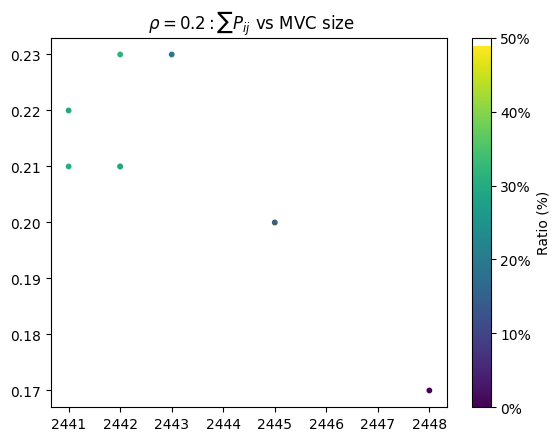

In [15]:
n_exp = 10
value = 0.2
rhos = np.full(n_exp, value)
ratios = np.random.uniform(0.0001, 0.5000, n_exp)
a = np.ones([DD1.shape[0]])/DD1.shape[0]
b = np.ones([DD2.shape[0]])/DD2.shape[0]
sot_options = {'penalty': 10, 'niter_sOT': 50000, 'f_init': np.zeros_like(a), 'g_init': np.zeros_like(b)}
A_sum_list = []
P_sum_list = []
Ratio_list = []

start_time = time.time() 

print("Only_sum:")

for i in range(n_exp):
    A, test = get_cover_sum_1(DD1, DD2, threshold=rhos[i], ratio=ratios[i])
    end_time = time.time()  # End timing
    print(f"Time taken: {end_time - start_time} seconds")
    
    if test == 0:
        print("error")
        break
        
    if test == 1:
        C = np.ones_like(A)
        C[np.where(A>0)] = np.inf
        P,_,_ = perform_sOT_log(C, a, b, 0.01, sot_options)
        print(i, int(A.sum()), P.sum(), ratios[i])
        A_sum_list.append(int(A.sum()))
        P_sum_list.append(P.sum())
        Ratio_list.append(ratios[i])

scatter = plt.scatter(A_sum_list, P_sum_list, s=10, c=ratios)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio (%)')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
plt.title(r' $\rho=0.2 : \sum P_{ij}$ vs MVC size')
plt.savefig('DiskDisk_test_sum_0113.png')


In [16]:
ratios

array([3.00972243e-04, 4.88381899e-01, 1.88352499e-01, 4.86894391e-01,
       3.02397579e-01, 4.14440019e-01, 2.87398281e-01, 3.14075292e-01,
       1.42859583e-01, 2.93457987e-01])